## Forecast_Planner ##
Aplicacion de pronóstico de demanda basado en AutoARIMA de Nixtla
- EXPERIMENTO 1, PROBANDO MODELO SOBRE DATOS CRUDOS



ATENCIÓN

Este Notebook es solamente para explicar y mostrar el desempeño de AutoARIMA basado en los primeros años de ventas del dataset, después se realiza backtest comparando con el ultimo año de ventas. En la aplicación final la fase de entrenamiento realiza el proceso de entrenamiento con todo el dataset proporcionado sin aportar más data sobre la exactitud del modelo (como es lógico). 

Esta entrenado sobre una versión modificada del dataset: https://www.kaggle.com/datasets/berkayalan/retail-sales-data/data

In [1]:
import pandas as pd


df = pd.read_excel('ventas_mensuales.xlsx')

PASO 1. Importar el modelo

In [2]:
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import matplotlib.pyplot as plt

modelo = StatsForecast(models=[AutoARIMA(season_length=12)], freq='MS', n_jobs=-1)


d:\CursoPython\Forecast_Planner\forecast_planner\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PASO 2. darle el formato necesario

In [3]:
dfl = pd.DataFrame()
dfl['unique_id'] = df['sucursal']+'_'+df['producto']
dfl['ds'] = pd.to_datetime(df['fecha'])
dfl['ds'] = df['fecha'].dt.strftime('%Y-%m-%d')
dfl['y'] = df['ventas']
dfl.head(5)



,unique_id,ds,y
0,S0001_P0001,2017-02-01,3
1,S0001_P0001,2017-11-01,0
2,S0001_P0001,2017-12-01,0
3,S0001_P0001,2018-01-01,1
4,S0001_P0001,2018-02-01,1


paso 3. dividir en df de entrenamiento y validacion

In [4]:
df_train = dfl[dfl['ds'] < '2019-01-01']
df_val = dfl[dfl['ds'] >= '2019-01-01']
df_val.head(5)

,unique_id,ds,y
15,S0001_P0001,2019-01-01,4
16,S0001_P0001,2019-02-01,3
17,S0001_P0001,2019-03-01,4
18,S0001_P0001,2019-04-01,3
19,S0001_P0001,2019-05-01,9


<Axes: title={'center': 'serie S0001_P0015'}, xlabel='Fecha', ylabel='Ventas'>

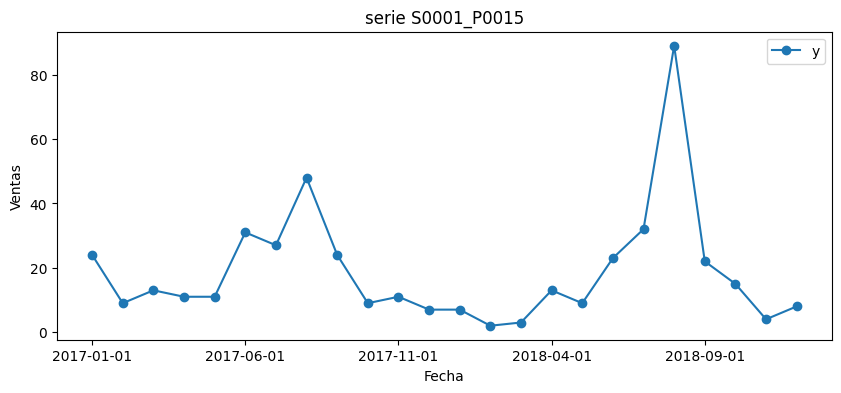

In [14]:
df_train[df_train['unique_id'] == 'S0001_P0015'].plot(
    x='ds', y='y',
    marker = 'o', figsize=(10,4),
    title="serie S0001_P0015",
    xlabel='Fecha', ylabel='Ventas'
)

Entrenar al modelo

In [6]:
modelo.fit(df=df_train)

StatsForecast(models=[AutoARIMA])

In [7]:
df_forecast = modelo.predict(h=12)

In [8]:
print(df_train.shape)
print(df_train['unique_id'].nunique())
df_forecast.head(5)

(431922, 3)
28750


,unique_id,ds,AutoARIMA
0,S0001_P0001,2019-01-01,6.4
1,S0001_P0001,2019-02-01,6.4
2,S0001_P0001,2019-03-01,6.4
3,S0001_P0001,2019-04-01,6.4
4,S0001_P0001,2019-05-01,6.4


Hacer el backtesing

In [9]:
df_val['ds'] = pd.to_datetime(df_val['ds'])
df_forecast['ds'] = pd.to_datetime(df_forecast['ds'])
df_bt = pd.merge(df_val, df_forecast, on = ['unique_id', 'ds'])
df_bt.head(5)

C:\Users\Martin\AppData\Local\Temp\ipykernel_9612\649399362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['ds'] = pd.to_datetime(df_val['ds'])


,unique_id,ds,y,AutoARIMA
0,S0001_P0001,2019-01-01,4,6.4
1,S0001_P0001,2019-02-01,3,6.4
2,S0001_P0001,2019-03-01,4,6.4
3,S0001_P0001,2019-04-01,3,6.4
4,S0001_P0001,2019-05-01,9,6.4


MAE y RMSE (hay ceros en y)

In [12]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(df_bt['y'], df_bt['AutoARIMA'])
rmse = np.sqrt(((df_bt['y'] - df_bt['AutoARIMA'])**2).mean())
print(f"MAE: {mae}\nRMSE: {rmse}")

MAE: 8.151527404785156
RMSE: 25.366438534452474


In [13]:
df_bt['y'].mean()

np.float64(9.703194263676837)

In [17]:
df_bt.to_excel('df_validacion.xlsx', index=False)

### CONCLUSIONES.


El MAE y RMSE muestran un rendimiento muy pobre del modelo. Se equivoca casi tanto como la propia venta promedio. El RMSE es aun peor.
Parece que no es recomendable usarlo, pero hemos de recordar que esto es raw data, y solo son dos años (24 registros), para el entrenamiento de cada serie. Intentaremos validar con una data procesada por nuestro algoritmo de limpieza y veremos como afecta al rendimiento.

Guardaremos dataframe de validacion para compararlo con el siguiente experimento en condiciones justas.